<a href="https://colab.research.google.com/github/nikitakaraevv/learning_laplace_beltrami/blob/master/nbs/Learning_LBO_FAUST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning LBO with PointNet

## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [0]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat, savemat
import matplotlib.pylab as plt
import scipy.sparse as sparse

In [2]:
!pip install path.py;
from path import Path

In [3]:
!git clone https://github.com/nikitakaraevv/learning_laplace_beltrami

Cloning into 'learning_laplace_beltrami'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 2), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [0]:
from learning_laplace_beltrami.src import utils

Download the FAUST dataset 

In [5]:
!gdown https://drive.google.com/uc?id=1nXYbykUctJn3UY9-yQnOVpW6PaHJhzFF

Downloading...
From: https://drive.google.com/uc?id=1nXYbykUctJn3UY9-yQnOVpW6PaHJhzFF
To: /content/FAUST.mat
1.24GB [00:07, 169MB/s]


In [0]:
data = loadmat('FAUST.mat');

In [7]:
ind = 0
mesh_data = data['Shape'][ind][0][0][0]
verts = mesh_data[0]
faces = mesh_data[1]-1
# Double precision is important here because sometimes we will have really small values
W = torch.DoubleTensor(mesh_data[14].todense(),); print('W:',W.size())
A = torch.DoubleTensor(mesh_data[15].todense()); print('A:',A.size())
φ = torch.DoubleTensor(mesh_data[16]); print('φ:',φ.size())
λ = torch.diag_embed(torch.DoubleTensor(mesh_data[17].squeeze())); print('λ:',λ.size())

W: torch.Size([6890, 6890])
A: torch.Size([6890, 6890])
φ: torch.Size([6890, 200])
λ: torch.Size([200, 200])


In [8]:
# check that eigenvalue equation holds
torch.abs(W.matmul(φ)-A.matmul(φ.matmul(λ))).sum()

tensor(0.0043, dtype=torch.float64)

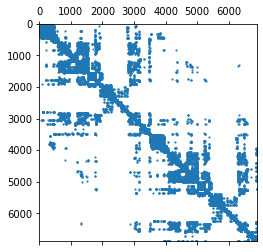

In [9]:
plt.spy(W, markersize=1)

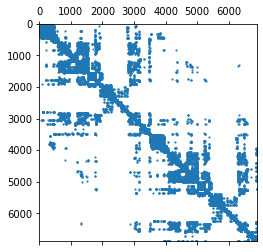

In [10]:
plt.spy(A, markersize=1)

In [11]:
if (W!=W.t()).sum()==0:
    print("W is symmetric")
if (A!=A.t()).sum()==0:
    print("A is symmetric")

W is symmetric
A is symmetric


In [0]:
i,j,k = np.array(faces).T
x,z,y = np.array(verts).T

In [13]:
utils.visualize_rotate([go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50, i=i,j=j,k=k)]).show()

In [14]:
utils.pcshow(x,y,z)

## Transforms

Sampling points on the surface uniformly with probabilities proportional to triangle areas

 ### Sample points

In [0]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        # changing the order of axes so that z is vertical
        verts = np.array(verts).T
        verts = np.stack((verts[0],verts[2],verts[1])).T
        
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, 
                                      weights=areas,
                                      cum_weights=None,
                                      k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        
        return sampled_points
    

In [0]:
pointcloud = PointSampler(6890)((verts, faces))

In [17]:
utils.pcshow(*pointcloud.T)

### Normalize

Normalize to a unit sphere

In [0]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [0]:
norm_pointcloud = Normalize()(pointcloud)

In [20]:
utils.pcshow(*norm_pointcloud.T)

Notice that axis limits have changed.

### Augmentations

Let's add *random rotation* of the whole pointcloud and random noise to its points.

In [0]:
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.005, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [0]:
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)

In [23]:
utils.pcshow(*noisy_rot_pointcloud.T)

### ToTensor

In [0]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.DoubleTensor(pointcloud)

In [0]:
def default_transforms():
    return transforms.Compose([
                                PointSampler(6890),
                                Normalize(),
                                ToTensor()
                              ])

## Dataset

Now we can create a [custom PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [0]:
class PointCloudData(Dataset):
    def __init__(self, data, valid=False, transform=default_transforms()):
        self.data = data
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid

    def __len__(self):
        return len(self.data)

    def __preproc__(self, verts, faces):
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        mesh_data = self.data[idx][0][0][0]
        verts = mesh_data[0]
        faces = mesh_data[1]-1

        # Double precision is important here because sometimes we will have really small values
        #W = torch.DoubleTensor(mesh_data[14].todense(),)
        #A = torch.DoubleTensor(mesh_data[15].todense())
        φ = torch.DoubleTensor(mesh_data[16])
        λ = torch.diag_embed(torch.DoubleTensor(mesh_data[17].squeeze()))
        
        

        pointcloud = self.__preproc__(verts, faces)
        return {'pointcloud': pointcloud, 
                'φ': φ,
                'φλ': φ.matmul(λ) }

In [0]:
train_ds = PointCloudData(data['Shape'][:80])
valid_ds = PointCloudData(data['Shape'][80:], valid=True)

In [28]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())

Train dataset size:  80
Valid dataset size:  20
Sample pointcloud shape:  torch.Size([6890, 3])


In [0]:
train_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=8)

## Model

In [30]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim


class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2]
        trans = self.stn(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat)
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts)
            return torch.cat([x, pointfeat], 1), trans, trans_feat

class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1), trans, trans_feat


class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat

class PointNetReg(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetReg, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 1024, 1)
        self.conv2 = torch.nn.Conv1d(1024, 512, 1)
        self.conv3 = torch.nn.Conv1d(512, self.k, 1)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = F.relu( self.bn1(self.conv1(x)) )
        x = F.relu( self.bn2(self.conv2(x)) )
        x = F.relu( self.conv3(x) )
        x = x.contiguous()
        
        #aa = torch.ones(n_pts);aa[0] = 0;
        #bb = torch.zeros(n_pts);bb[0]=1;
        #x = F.relu(x*aa) + x*bb;
        
        x = x.view(batchsize, n_pts, self.k)
        return x, trans, trans_feat    

def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

if __name__ == '__main__':
    sim_data = Variable(torch.rand(8,3,6890))
    trans = STN3d()
    out = trans(sim_data)
    print('stn', out.size())
    print('loss', feature_transform_regularizer(out))

    sim_data_64d = Variable(torch.rand(32, 64, 2500))
    trans = STNkd(k=64)
    out = trans(sim_data_64d)
    print('stn64d', out.size())
    print('loss', feature_transform_regularizer(out))

    pointfeat = PointNetfeat(global_feat=True)
    out, _, _ = pointfeat(sim_data)
    print('global feat', out.size())

    pointfeat = PointNetfeat(global_feat=False)
    out, _, _ = pointfeat(sim_data)
    print('point feat', out.size())

    cls = PointNetCls(k = 5)
    out, _, _ = cls(sim_data)
    print('class', out.size())

    seg = PointNetDenseCls(k = 3)
    out, _, _ = seg(sim_data)
    print('seg', out.size())
    
    reg = PointNetReg(k = 400)
    out, _, _ = reg(sim_data)
    print('reg', out.size())

stn torch.Size([8, 3, 3])
loss tensor(1.8644, grad_fn=<MeanBackward0>)
stn64d torch.Size([32, 64, 64])
loss tensor(127.4789, grad_fn=<MeanBackward0>)
global feat torch.Size([8, 1024])
point feat torch.Size([8, 1088, 6890])
class torch.Size([8, 5])
seg torch.Size([8, 6890, 3])
reg torch.Size([8, 6890, 400])


## Training loop

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
weightNet = PointNetReg(k = 400, feature_transform = False).to(device) 
optimizer = optim.Adam(weightNet.parameters(), lr=1e-3, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.75)


In [0]:
batch = next(iter(train_loader))
pcd, φ, φλ = batch['pointcloud'], batch['φ'], batch['φλ']

In [34]:
pcd.size()

torch.Size([8, 6890, 3])

In [0]:
def train(model, train_loader, val_loader=None,  epochs=200, save=True, freq=10):
    for epoch in range(epochs): 
        weightNet.train()
        running_loss = 0.0
        for i, batch in enumerate(train_loader, 0):
            pcd = batch['pointcloud'].to(device).float()
            φ  =  batch['φ'].to(device).float()
            φλ =  batch['φλ'].to(device).float()

            optimizer.zero_grad()
            outputs, __, __ = weightNet(pcd.transpose(1,2))
            L = torch.bmm(outputs, outputs.transpose(1,2))
            loss = F.mse_loss(torch.bmm(L, φ), φλ)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % freq == freq-1:    # print every {freq} mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / freq))
                    running_loss = 0.0
            del pcd
            del φ
            del φλ

        # validation
        weightNet.eval()
        total = 0.
        val_loss = 0.0
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    pcd = batch['pointcloud'].to(device).float()
                    φ  =  batch['φ'].to(device).float()
                    φλ =  batch['φλ'].to(device).float()

                    outputs, __, __ = weightNet(pcd.transpose(1,2))
                    L = torch.bmm(outputs, outputs.transpose(1,2))
                    loss = F.mse_loss(torch.bmm(L, φ), φλ)
                    total += 1.
                    val_loss += loss.item()
                del pcd
                del φ
                del φλ
            val_loss /= total
            print('Valid loss: %d' % val_loss)

        # save the model
        if save:
            torch.save(weightNet.state_dict(), "save_"+str(epoch)+".pth")

In [0]:
train(weightNet, train_loader, valid_loader,  save=False, freq=1)

[Epoch: 1, Batch:    1 /   10], loss: 227069216.000
[Epoch: 1, Batch:    2 /   10], loss: 32548232.000
[Epoch: 1, Batch:    3 /   10], loss: 1507616.750
[Epoch: 1, Batch:    4 /   10], loss: 716540.750
[Epoch: 1, Batch:    5 /   10], loss: 487210.125
[Epoch: 1, Batch:    6 /   10], loss: 482348.281
[Epoch: 1, Batch:    7 /   10], loss: 495256.875
[Epoch: 1, Batch:    8 /   10], loss: 486047.688
[Epoch: 1, Batch:    9 /   10], loss: 442664.438
[Epoch: 1, Batch:   10 /   10], loss: 475486.219
Valid loss: 473709
[Epoch: 2, Batch:    1 /   10], loss: 378128.125
[Epoch: 2, Batch:    2 /   10], loss: 489573.406
[Epoch: 2, Batch:    3 /   10], loss: 443149.875
[Epoch: 2, Batch:    4 /   10], loss: 513769.531
[Epoch: 2, Batch:    5 /   10], loss: 427052.750
[Epoch: 2, Batch:    6 /   10], loss: 505453.594
[Epoch: 2, Batch:    7 /   10], loss: 415879.469
[Epoch: 2, Batch:    8 /   10], loss: 473051.062
[Epoch: 2, Batch:    9 /   10], loss: 431081.219
[Epoch: 2, Batch:   10 /   10], loss: 403243